### Building Random Co-Polymers
### Joe Laforet Jr.
#### jola3134@colorado.edu

This notebook serves as a self-contained utility for a user to input SMILES strings of monomers that can react together to form a polymer according to Atom-Transfer Radical Polymerization.

We assume that the user will input some sort of methacrylate monomer that will be polymerized according to ATRP. If you want to use a non-methacrylate monomer or some other reaction mechanism, you must write a new reaction schema. The core concepts outlined in this tutorial should transfer to your new problem.

Information is broken up to the following schema:
## Table of Contents
- 0.0 Logging/Imports
- 1.0 Input Monomers
- 1.1 Initiation
- 1.2 Polymerization
- 1.3 Termination
- 2.0 Build a Linear Polymer


---

<a id='loggingimports'></a>

#### 0.0 Logging/Imports
In this section, we set up our Python environment, import required packages, and configure logging to track progress throughout the polymerization workflow.

---

In [1]:
import logging
logging.basicConfig(level=logging.INFO, force=True)

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import MolsToGridImage
from polymerist.rdutils.rdkdraw import set_rdkdraw_size, disable_substruct_highlights, disable_kekulized_drawing

MOL_IMG_WIDTH  : int = 300
MOL_IMG_HEIGHT : int = 200
MOL_IMG_SIZE = (MOL_IMG_WIDTH, MOL_IMG_HEIGHT)

disable_kekulized_drawing()
disable_substruct_highlights()
set_rdkdraw_size(MOL_IMG_WIDTH, MOL_IMG_WIDTH / MOL_IMG_HEIGHT)

from pathlib import Path
from polymerist.genutils.fileutils.pathutils import assemble_path

OUTPUT_DIR = Path('Building_Demos') # dummy directory for writing without tampering with example inputs
OUTPUT_DIR.mkdir(exist_ok=True)

WORKING_DIR = OUTPUT_DIR / 'ATRP_demo'
WORKING_DIR.mkdir(exist_ok=True)

REACTIONS_DIR = WORKING_DIR / "Reactions"
REACTIONS_DIR.mkdir(exist_ok=True)

project_name : str = 'ATRP_polymer_brush'

INFO:rdkit:Enabling RDKit 2023.09.6 jupyter extensions
INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


### The below cells demonstrate how one would write reaction files to build a polymer. They are for educational purposes. You can skip to **Build a Linear Polymer** if you are happy with just using this as a black box.

<a id='input-monomers'></a>
#### 1.0 Input Monomers


The user specifies the building blocks of the polymer by providing SMILES strings.  
For simplicity, we assume methacrylate-based monomers, but the procedure can be adapted to other chemistries.
NOTE: We also add Cl2 as a reactant so we can chlorinate the alkene!


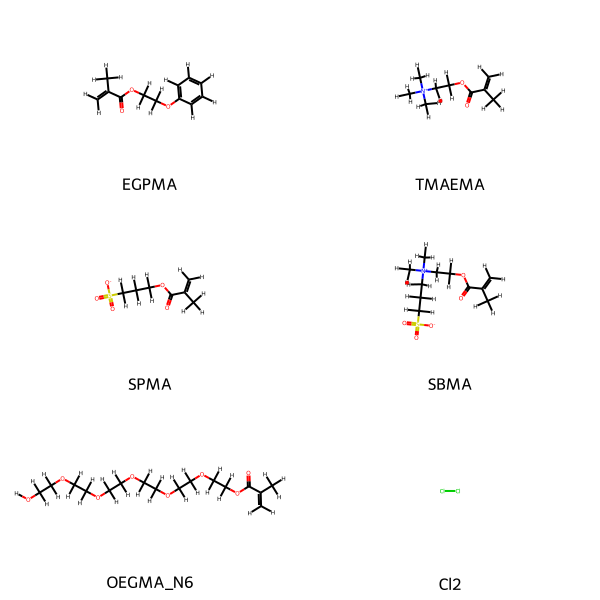

In [2]:
from polymerist.rdutils.reactions.reactors import PolymerizationReactor

from polymerist.rdutils.sanitization import explicit_mol_from_SMILES, Smiles

# SMILES w/o Cl activation
monomer_smiles : dict[str, str] = {
    'EGPMA'    : '[H]C([H])=C(C(=O)OC([H])([H])C([H])([H])Oc1c([H])c([H])c([H])c([H])c1[H])C([H])([H])[H]',
    'TMAEMA'   : '[H]C([H])=C(C(=O)OC([H])([H])C([H])([H])[N+](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])[H]',
    'SPMA'     : '[H]C([H])=C(C(=O)OC([H])([H])C([H])([H])C([H])([H])S(=O)(=O)[O-])C([H])([H])[H]',
    'SBMA'     : '[H]C([H])=C(C(=O)OC([H])([H])C([H])([H])[N+](C([H])([H])[H])(C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])S(=O)(=O)[O-])C([H])([H])[H]',
    'OEGMA_N6' : '[H]OC([H])([H])C([H])([H])OC([H])([H])C([H])([H])OC([H])([H])C([H])([H])OC([H])([H])C([H])([H])OC([H])([H])C([H])([H])OC([H])([H])C([H])([H])OC(=O)C(=C([H])[H])C([H])([H])[H]',
    'Cl2'      : '[Cl]-[Cl]'
}

monomers : dict[str, Chem.Mol] = {
    name : explicit_mol_from_SMILES(smiles)
        for name, smiles in monomer_smiles.items()
}

MolsToGridImage(monomers.values(), molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=monomers.keys())


#### 1.1 Initiation (Halogenation of an Alkene)


In [3]:
from polymerist.rdutils.reactions.assembly import ReactionAssembler

methyl_methacrylate = Chem.MolFromSmarts('[C:1]=[C:2](-[C:3])-[C:4](=[O:5])-[O:6]-[*:7]')
dichlorine = Chem.MolFromSmarts('[Cl:1]-[Cl:2]')

#display(methyl_methacrylate)
#display(dichlorine)

assembler = ReactionAssembler(
    reactive_groups=[  # reaction takes place between Cl2 and MMA
        dichlorine,
        methyl_methacrylate,
    ],
    #byproducts=None, 
    rxn_name='Alkene Chlorination',
)
#display(assembler.reactants)

assembler.bond_derangement = {
    1 : (2, 4), # keys are the indices of pivot atoms; 
    3 : (4, 2), # values are the atom indices to which the pivot was and will be bonded, respectively
}

ATRP_initiation_rxn = assembler.assemble_rxn(show_steps=False)
#display(ATRP_initiation_rxn)

ATRP_initiation_rxn.to_rxnfile(REACTIONS_DIR / 'atrp_initiation.rxn')


#### Define the polymerization reaction, linking a tertiary chlorinated methyl-methacrylate to a primary chlorinated methyl-methacrylate

In [4]:
# Try and define two polymerizations, one for each Cl site
mma_chloro_tertC = Chem.MolFromSmarts('[C:1]-[C:2](-[Cl:8])(-[C:3]-[*:9])-[C:4](=[O:5])-[O:6]-[*:7]')
mma_chloro_primC = Chem.MolFromSmarts('[C:1]-[C:2](-[*:8])(-[C:3]-[Cl:9])-[C:4](=[O:5])-[O:6]-[*:7]')

# display(mma_chloro_primC)
# display(mma_chloro_tertC)

In [5]:
from rdkit.Chem import rdChemReactions, Draw
print("INITIATION")
#Draw.ReactionToImage(ATRP_initiation_rxn, subImgSize=(300,300))

INITIATION


In [6]:
# One round of methacrylate polymerization
rxn = rdChemReactions.ReactionFromSmarts('[C:1](=[C:2](-[C:3])-[C:4](=[O:5])-[O:6]-[*:7]).[C:13](=[C:12](-[C:14])-[C:11](=[O:10])-[O:9]-[*:8])>>[C:1](-[C:2](-[C:13](-[C:12](=[C:14])-[C:11](=[O:10])-[O:9]-[*:8]))(-[C:3])-[C:4](=[O:5])-[O:6]-[*:7])')
print("ONE-ROUND POLYMERIZATION")
#Draw.ReactionToImage(rxn, subImgSize=(300,300))


ONE-ROUND POLYMERIZATION


In [7]:
# Two rounds of methacrylate polyemerization
rxn = rdChemReactions.ReactionFromSmarts('[C:1](-[C:2](-[C:13](-[C:12](=[C:14])-[C:11](=[O:10])-[O:9]-[*:8]))(-[C:3])-[C:4](=[O:5])-[O:6]-[*:7]).[C:20](=[C:19](-[C:21])-[C:18](=[O:17])-[O:16]-[*:15])>>[C:1](-[C:2](-[C:13](-[C:12](-[C:14]-[C:20](-[C:19](=[C:21])-[C:18](=[O:17])-[O:16]-[*:15]))-[C:11](=[O:10])-[O:9]-[*:8]))(-[C:3])-[C:4](=[O:5])-[O:6]-[*:7])')
print("TWO-ROUNDS POLYMERIZATION")
#Draw.ReactionToImage(rxn, subImgSize=(300,300))

TWO-ROUNDS POLYMERIZATION


In [8]:
# assembler = ReactionAssembler(
#     reactive_groups=[  # reaction takes place between two alkyl chlorides
#         mma_chloro_primC,
#         mma_chloro_primC,
#     ],
#     byproducts=[Chem.MolFromSmarts('[Cl]-[Cl]')], # eject Cl2 byproduct
#     rxn_name='atom-transfer radical polymerization',
# )
# display(assembler.reactants)

# assembler.bond_derangement = {
#     13 : (14, 4), # keys are the indices of pivot atoms; values are the atom indices to which the pivot was and will be bonded, respectively
#     5 : (4, 14),    
# }

# ATRP_polymerization_primC_primC_rxn = assembler.assemble_rxn(show_steps=True)
# display(ATRP_polymerization_primC_primC_rxn)

In [9]:
assembler = ReactionAssembler(
    reactive_groups=[  # reaction takes place between two alkyl chlorides
        mma_chloro_primC,
        mma_chloro_tertC,
    ],
    byproducts=[Chem.MolFromSmarts('[Cl]-[Cl]')], # eject Cl2 byproduct
    rxn_name='atom-transfer radical polymerization',
)
#display(assembler.reactants)

assembler.bond_derangement = {
    11 : (12, 4), # keys are the indices of pivot atoms; values are the atom indices to which the pivot was and will be bonded, respectively
    5 : (4, 12),    
}

ATRP_polymerization_primC_tertC_rxn = assembler.assemble_rxn(show_steps=False)
#display(ATRP_polymerization_primC_tertC_rxn)
ATRP_polymerization_primC_tertC_rxn.to_rxnfile(REACTIONS_DIR / 'atrp_polymerization.rxn')

In [10]:
# assembler = ReactionAssembler(
#     reactive_groups=[  # reaction takes place between two alkyl chlorides
#         mma_chloro_tertC,
#         mma_chloro_tertC,
#     ],
#     byproducts=[Chem.MolFromSmarts('[Cl]-[Cl]')], # eject Cl2 byproduct
#     rxn_name='atom-transfer radical polymerization',
# )
# display(assembler.reactants)

# assembler.bond_derangement = {
#     11 : (12, 2), # keys are the indices of pivot atoms; values are the atom indices to which the pivot was and will be bonded, respectively
#     3  : (2, 12),    
# }

# ATRP_polymerization_tertC_tertC_rxn = assembler.assemble_rxn(show_steps=True)
# display(ATRP_polymerization_tertC_tertC_rxn)


In [11]:
# from rdkit import Chem
# from polymerist.rdutils.reactions.assembly import ReactionAssembler

# alkyl_chloride_1c = Chem.MolFromSmarts('[*:1]-[C:2]-[Cl:3]')  # this is the moiety active in the ATRP reaction
# alkyl_chloride_2c = Chem.MolFromSmarts('[*:1]-[C:2]-[C:3]-[Cl:4]')  # this is the moiety active in the ATRP reaction
# assembler = ReactionAssembler(
#     reactive_groups=[  # reaction takes place between two alkyl chlorides
#         Chem.Mol(alkyl_chloride_1c),
#         Chem.Mol(alkyl_chloride_2c),
#     ],
#     byproducts=[Chem.MolFromSmarts('[Cl]-[Cl]')], # eject Cl2 byproduct
#     rxn_name='atom-transfer radical polymerization',
# )
# display(assembler.reactants)

# assembler.bond_derangement = {
#     6 : (7, 2), # keys are the indices of pivot atoms; values are the atom indices to which the pivot was and will be bonded, respectively
#     3 : (2, 7),    
# }
# ATRP_polymerization_rxn = assembler.assemble_rxn(show_steps=True)
# display(ATRP_polymerization_rxn)

# ATRP_polymerization_rxn.to_rxnfile(REACTIONS_DIR / 'atrp_polymerization.rxn')


#### Run Initiation on all monomers

In [12]:
from polymerist.rdutils.reactions.reactors import PolymerizationReactor

initiation_reactor = PolymerizationReactor(ATRP_initiation_rxn)
starting_monomers = initiation_reactor.propagate_pooled(
    monomers.values(),
    rxn_depth_max=0,
    clear_dummy_labels=True, # this makes identifying fragment superstructure easier in the following step
)
#MolsToGridImage(starting_monomers.values(), molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=starting_monomers.keys())


In [13]:
activated_monomers = initiation_reactor.propagate_pooled(
    monomers.values(),
    rxn_depth_max=1,
    clear_dummy_labels=True, # this makes identifying fragment superstructure easier in the following step
)

to_remove = []
for x in activated_monomers:
    if x in starting_monomers:
        to_remove.append(x)

for x in to_remove:
    activated_monomers.pop(x, None)

#MolsToGridImage(activated_monomers.values(), molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=activated_monomers.keys())

INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 1 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 5 new fragments formable after at least 1 reaction step(s)


#### Convert the SMILES of activated monomers into names and spec-compliant SMARTS

In [14]:
#MolsToGridImage(activated_monomers.values(), molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=activated_monomers.keys())

In [15]:
from rdkit.Chem import rdFMCS

def partial_substruct_match(mol, query, threshold=0.8):
    mcs = rdFMCS.FindMCS([mol, query],
                         completeRingsOnly=False,
                         matchValences=False,
                         ringMatchesRingOnly=False,
                         timeout=5)
    if not mcs.smartsString:
        return False
    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
    n_mcs_atoms = mcs_mol.GetNumAtoms()
    n_query_atoms = query.GetNumAtoms()
    return (n_mcs_atoms / n_query_atoms) >= threshold

def find_first_partial_match(monomers, query_mol, threshold=0.77):
    for name, monomer in monomers.items():
        if partial_substruct_match(monomer, query_mol, threshold=threshold):
            return name  # return first match immediately
    return None  # no match found


In [16]:
from polymerist.polymers.monomers import MonomerGroup
from polymerist.rdutils.bonding.portlib import get_num_ports

activated_named_monomers_Smiles : dict[str, Smiles] = {}
for canon_smiles, fragment_mol in activated_monomers.items():
    
    # find the parent monomer that contains this fragment
    query_mol = Chem.MolFromSmarts(canon_smiles) 
    parent_mol_name = find_first_partial_match(monomers, query_mol, threshold=0.77)
    
    print(parent_mol_name)
    activated_named_monomers_Smiles[f'{parent_mol_name}'] = canon_smiles

    
monogrp = MonomerGroup(activated_named_monomers_Smiles)
#MolsToGridImage([mol for _, mol in monogrp.iter_rdmols()], molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=monogrp.monomers.keys())

EGPMA
TMAEMA
SPMA
SBMA
OEGMA_N6


#### Run the polymerization reaction on activated monomers

In [17]:
activated_named_monomers : dict[str, Chem.Mol] = {
    name : explicit_mol_from_SMILES(smiles)
        for name, smiles in activated_named_monomers_Smiles.items()
}

activated_named_monomers

{'EGPMA': <rdkit.Chem.rdchem.Mol at 0x1533cd4a3e60>,
 'TMAEMA': <rdkit.Chem.rdchem.Mol at 0x1533cd4a3df0>,
 'SPMA': <rdkit.Chem.rdchem.Mol at 0x1533cd4a3ed0>,
 'SBMA': <rdkit.Chem.rdchem.Mol at 0x1533cd4a3d80>,
 'OEGMA_N6': <rdkit.Chem.rdchem.Mol at 0x1533ccadc0b0>}

In [18]:
from polymerist.rdutils.reactions.reactors import PolymerizationReactor

#reactor = PolymerizationReactor(ATRP_polymerization_rxn)
reactor =  PolymerizationReactor(ATRP_polymerization_primC_tertC_rxn)
activated_fragments = reactor.propagate_pooled(
    activated_named_monomers.values(),
    rxn_depth_max=5,
    clear_dummy_labels=True, # this makes identifying fragment superstructure easier in the following step
    allow_resampling=True, 
)
#MolsToGridImage(activated_fragments.values(), molsPerRow=5, subImgSize=MOL_IMG_SIZE, legends=activated_fragments.keys())

INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 1 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 10 new fragments formable after at least 1 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 2 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 5 new fragments formable after at least 2 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 3 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 0 new fragments formable after at least 3 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:HALTING NORMALLY: No new reaction fragments discovered requiring 3 reaction step(s) or more


#### Rename the fragments ready for polymerization

In [19]:
from string import ascii_lowercase
from collections import defaultdict, Counter

from polymerist.polymers.monomers import MonomerGroup
from polymerist.rdutils.bonding.portlib import get_num_ports
from polymerist.genutils.iteration import sort_dict_by_keys


named_fragments : dict[str, Smiles] = {}
fragment_name_modifiers = defaultdict(Counter) # keeps track of how many times each (monomer name, functionality) pair is found to generate distinguishing suffixes

for canon_smiles, fragment_mol in activated_fragments.items():
    functionality = get_num_ports(fragment_mol)
    if functionality == 0:
        continue # skip fragments with no ports, as these are not useful for polymerization
    
    # find the parent monomer that contains this fragment
    query_mol = Chem.MolFromSmarts(canon_smiles) 
    parent_mol_name = find_first_partial_match(monomers, query_mol, threshold=0.77)

    suffix = ascii_lowercase[fragment_name_modifiers[parent_mol_name][functionality]]
    named_fragments[f'{parent_mol_name}-{functionality}{suffix}'] = canon_smiles
    fragment_name_modifiers[parent_mol_name][functionality] += 1
    
monogrp = MonomerGroup(sort_dict_by_keys(named_fragments, reverse=True)) # sorting is not necessary for any functionality, but groups like fragments together for viewing 
#MolsToGridImage([mol for _, mol in monogrp.iter_rdmols()], molsPerRow=5, subImgSize=MOL_IMG_SIZE, legends=monogrp.monomers.keys())

In [20]:
# from polymerist.polymers.monomers import MonomerGroup
# from polymerist.rdutils.bonding.portlib import get_num_ports

# named_fragments : dict[str, Smiles] = {}
# for canon_smiles, fragment_mol in activated_fragments.items():
#     functionality = get_num_ports(fragment_mol)
#     if functionality == 0:
#         continue # skip fragments with no ports, as these are not useful for polymerization
    
#     # find the parent monomer that contains this fragment
#     query_mol = Chem.MolFromSmarts(canon_smiles) 
#     parent_mol_name = find_first_partial_match(monomers, query_mol, threshold=0.77)
#     named_fragments[f'{parent_mol_name}_{functionality}-site'] = canon_smiles
    
# monogrp = MonomerGroup(named_fragments)
# MolsToGridImage([mol for _, mol in monogrp.iter_rdmols()], molsPerRow=3, subImgSize=MOL_IMG_SIZE, legends=monogrp.monomers.keys())

In [21]:
# activated because these have Cl, named because they are labeled by
# a semantically meaningful name
activated_named_fragments : dict[str, Chem.Mol] = {
    name : explicit_mol_from_SMILES(smiles)
        for name, smiles in named_fragments.items()
}

#MolsToGridImage(activated_named_fragments.values(), molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=activated_named_fragments.keys())

#### Terminate the 1-site fragments
* According to the ATRP polymerization mechanism, we want to preserve the terminal alkenes for our 1-sites
* The above chemistry generated two different types of 1-sites (a,b).
* We will run a termination reaction on the tertiary alkyl chlorides and then use those for our final
* Reaction library

In [22]:
term_rxn_tertiary = AllChem.ReactionFromSmarts("[C:3]-[C:2](-[Cl])(-[C:1]-[*:8])-[C:4](=[O:5])-[O:6]-[*:7] >> [C:3]=[C:2](-[C:1]-[*:8])-[C:4](=[O:5])-[O:6]-[*:7]")
#display(term_rxn_tertiary)

In [23]:
term_rxn_primary = AllChem.ReactionFromSmarts("[C:3]-[C:2](-[*])(-[C:1]-[Cl:8])-[C:4](=[O:5])-[O:6]-[*:7].[H:9]-[Cl:10] >> [C:3]-[C:2](-[*])(-[C:1]-[H:9])-[C:4](=[O:5])-[O:6]-[*:7].[Cl:8]-[Cl:10]")
#display(term_rxn_primary)

In [24]:
from rdkit import Chem
from polymerist.rdutils.reactions.assembly import ReactionAssembler

# ATRP ends with the alkene re-forming. This means we need to terminate on our tertiary C one-sites
chlor_methyl_methacrylate = Chem.MolFromSmarts('[Cl:3]-[C:2](-[*:9])(-[C:1](-[H])(-[H])-[H])-[C:4](=[O:5])-[O:6]-[*:7]')  # this is the moiety active in the ATRP reaction

assembler = ReactionAssembler(
    reactive_groups=[  # reaction takes place between our reactive methacrylate and an imaginary HCl
        Chem.Mol(chlor_methyl_methacrylate),
        Chem.Mol(Chem.MolFromSmarts("[H]-[Cl]"))
    ],
    byproducts=[Chem.MolFromSmarts('[Cl]-[Cl]'), Chem.MolFromSmarts('[H]-[H]')], # eject Cl2 byproduct
    rxn_name='Termination',
)
#display(assembler.reactants)

assembler.bond_derangement = {
    2 : (1, 4), # keys are the indices of pivot atoms; 
    13: (12, 1), # values are the atom indices to which
    5 : (4, 12)  # the pivot was and will be bonded, respectively    
}

termination_rxn = assembler.assemble_rxn(show_steps=False)
#display(termination_rxn)

termination_rxn.to_rxnfile(REACTIONS_DIR / 'atrp_termination.rxn')


[18:08:07] reactant 1 has no mapped atoms.
[18:08:07] reactant 1 has no mapped atoms.


In [25]:
# Add in HCl so we can run termination
# We need to explicitly include this extra molecule in the
# Pool of reactants
activated_named_fragments["HCl"] = Chem.MolFromSmarts("[H]-[Cl]")

termination_reactor = PolymerizationReactor(termination_rxn)
terminated_fragments = termination_reactor.propagate_pooled(
    activated_named_fragments.values(),
    # rxn_depth_max=3,
    clear_dummy_labels=True, # this makes identifying fragment superstructure easier in the following step
)
#MolsToGridImage(terminated_fragments.values(), molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=terminated_fragments.keys())

INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 1 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 5 new fragments formable after at least 1 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 2 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 0 new fragments formable after at least 2 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:HALTING NORMALLY: No new reaction fragments discovered requiring 2 reaction step(s) or more


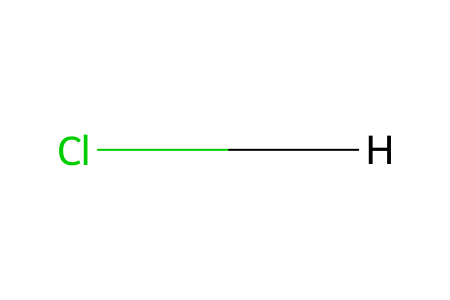

In [26]:
# Remove all of the non-fragments
to_remove = []
for x in terminated_fragments:
    if x in activated_fragments:
        to_remove.append(x)

for x in to_remove:
    terminated_fragments.pop(x, None)

terminated_fragments.pop('Cl', None) # Get rid of the Cl we added

#MolsToGridImage(terminated_fragments.values(), molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=terminated_fragments.keys())

In [27]:
terminated_named_monomers_Smiles : dict[str, Smiles] = {}
for canon_smiles, fragment_mol in terminated_fragments.items():

    # find the parent monomer that contains this fragment
    query_mol = Chem.MolFromSmarts(canon_smiles) 
    parent_mol_name = find_first_partial_match(activated_named_fragments, query_mol, threshold=0.77)
    
    terminated_named_monomers_Smiles[f'{parent_mol_name.split("-")[0]+"_1-site"}'] = canon_smiles

monogrp = MonomerGroup(terminated_named_monomers_Smiles)
#MolsToGridImage([mol for _, mol in monogrp.iter_rdmols()], molsPerRow=3, subImgSize=MOL_IMG_SIZE, legends=monogrp.monomers.keys())

In [28]:
# Get the mapping from smiles to molecule
terminated_named_fragments: dict[str, Chem.Mol] = {
    name : explicit_mol_from_SMILES(smiles)
        for name, smiles in terminated_named_monomers_Smiles.items()
}

terminated_named_fragments

{'EGPMA_1-site': <rdkit.Chem.rdchem.Mol at 0x1533ccade9d0>,
 'TMAEMA_1-site': <rdkit.Chem.rdchem.Mol at 0x1533ccaddfc0>,
 'SPMA_1-site': <rdkit.Chem.rdchem.Mol at 0x1533ccade420>,
 'SBMA_1-site': <rdkit.Chem.rdchem.Mol at 0x1533ccade810>,
 'OEGMA_N6_1-site': <rdkit.Chem.rdchem.Mol at 0x1533ccaddf50>}

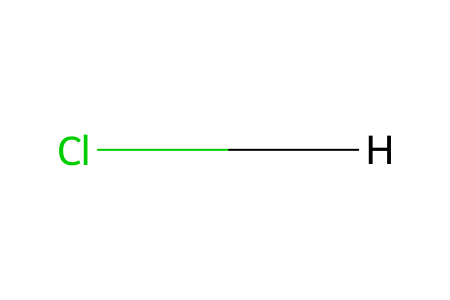

In [29]:
# Remove HCl from activated_named_fragments
# Pull out the 2-sites from activated_named_fragments (they're correct)
# Merge with the terminated 1-sites (we just made these)
# Write to a MonomerGroup

activated_named_fragments.pop("HCl", None)

In [30]:
two_site_fragments = {}

for x in activated_named_fragments.keys():
    if "2" in x:
        new_name = x.split("-")[0] + "_2-site"

        two_site_fragments[new_name] = activated_named_fragments[x]

two_site_fragments



{'EGPMA_2-site': <rdkit.Chem.rdchem.Mol at 0x1533ccadd7e0>,
 'TMAEMA_2-site': <rdkit.Chem.rdchem.Mol at 0x1533ccadd850>,
 'SPMA_2-site': <rdkit.Chem.rdchem.Mol at 0x1533ccadd8c0>,
 'SBMA_2-site': <rdkit.Chem.rdchem.Mol at 0x1533ccadd930>,
 'OEGMA_N6_2-site': <rdkit.Chem.rdchem.Mol at 0x1533ccadd9a0>}

In [31]:
# Take the union of these dicts, the right hand dict takes precedence
# When keys are shared

all_correct_named_fragments = two_site_fragments | terminated_named_fragments
#MolsToGridImage(all_correct_named_fragments.values(), molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=all_correct_named_fragments.keys())

In [32]:
# Put everything into a MonomerGroup
all_correct_named_fragments_Smiles : dict[str, Smiles] = {}

for parent_mol_name, fragment_mol in all_correct_named_fragments.items():
    # find the parent monomer that contains this fragment
    query_mol = Chem.MolFromSmarts(canon_smiles) 
    all_correct_named_fragments_Smiles[parent_mol_name] = Chem.MolToSmarts(fragment_mol)

monogrp = MonomerGroup(all_correct_named_fragments_Smiles)
#MolsToGridImage([mol for _, mol in monogrp.iter_rdmols()], molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=monogrp.monomers.keys())

In [33]:
fragments_path = assemble_path(WORKING_DIR, project_name, postfix='fragments', extension='json')
monogrp.to_file(fragments_path)
# for name, residue in monogrp.iter_rdmols():
#     print(name)
#     display(residue)

#### 2.0: Build a linear polymer
* Note, can skip all above content if just interested in building polymers

In [34]:
# OPTIONAL
# Load in fragment files from cache
fragments_path = assemble_path(WORKING_DIR, project_name, postfix='fragments', extension='json')
monogrp = MonomerGroup.from_file(fragments_path)

In [35]:
import numpy as np

# draw probabilities according to experiment
# 3:3:2 + 5% SBMA, SPMA, OEGMA, EGPMA, TMAEMA

probas = [0.3583, 0.3583, 0.2334, 0.05, 0.0]
chars = ['D', 'C', 'E', 'A', 'B']
N = 10

# Make mapper dict for the one-sites
# These will be used to terminate the polymer
term_orient_mapper = {
    'D' : 'SBMA_1-site',
    'C' : 'SPMA_1-site',
    'E' : 'OEGMA_N6_1-site',
    'A' : 'EGPMA_1-site',
    'B' : 'TMAEMA_1-site'
}

# rename to 3-letter residue names in PDB file
resname_map={ 
        'SBMA_1-site'     : 'SB1',
        'SBMA_2-site'     : 'SB2',
        'SPMA_1-site'     : 'SP1',
        'SPMA_2-site'     : 'SP2',
        'OEGMA_N6_1-site' : 'OE1',
        'OEGMA_N6_2-site' : 'OE2',
        'EGPMA_1-site'    : 'EG1',
        'EGPMA_2-site'    : 'EG2',
        'TMAEMA_1-site'   : 'TM1',
        'TMAEMA_2-site'   : 'TM2'
    }

# sample N characters according to the probabilities
polymer_seq = ''.join(np.random.choice(chars, size=N, p=probas))

# Define a canonical form: min of the string and its reverse
def canonical(s):
    return min(s, s[::-1])

# Convert all strings to their canonical form
canonical_poly_seq = canonical(polymer_seq) 

print("Raw Polymer Sequence:", ''.join(polymer_seq))
print("Canonical Polymer Sequence:", ''.join(canonical_poly_seq))

Raw Polymer Sequence: EDDEDDDCCE
Canonical Polymer Sequence: ECCDDDEDDE


In [36]:
from polymerist.polymers.building import build_linear_polymer, mbmol_to_openmm_pdb, mbmol_to_rdkit_pdb
from polymerist.rdutils.rdcoords.piercing import summarize_ring_piercing
from polymerist.polymers.building import build_linear_polymer, mbmol_to_rdkit_pdb
from polymerist.polymers.building import mbmol_to_rdmol

                      # JRL: I don't think the below comment is correct
n_monomers : int = N  # number of MIDDLE monomers (not including end groups)

# not strictly necessary, but nice to show you can reload these fragments from prior builds
# monogrp = MonomerGroup.from_file(fragments_path)
monogrp.term_orient = { # set explicit orientation for head and tail terminal groups
    'head' : term_orient_mapper[canonical_poly_seq[0]],
    'tail' : term_orient_mapper[canonical_poly_seq[-1]],
}

successful_build = False
while not successful_build:

# assemble polymer chain
    chain = build_linear_polymer(
        monogrp,
        n_monomers=n_monomers,
        sequence=canonical_poly_seq[1:-1], # omit the head and tail groups
        energy_minimize=True,
        allow_partial_sequences=True
    )

    poly_mol = mbmol_to_rdmol(chain)
    pinprics_out = summarize_ring_piercing(poly_mol)

    if pinprics_out == {}:
        successful_build = True
        print("Build Success!")
    else:
        print("PIERCING REDO")
        print(pinprics_out)


polymer_name = f'{canonical_poly_seq}_{n_monomers}-mer'
pdb_path = assemble_path(WORKING_DIR, polymer_name, extension='pdb')
mbmol_to_openmm_pdb(
    pdb_path,
    chain,
    resname_map=resname_map
)

chain.visualize()

# draw probabilities according to experiment
# 3:3:2 + 5% SBMA, SPMA, OEGMA, EGPMA, TMAEMA

probas = [0.3583, 0.3583, 0.2334, 0.05,  0.0]
chars  = [    'D',   'C',    'E',  'A',  'B']

[18:08:24] WARNING: not removing hydrogen atom with dummy atom neighbors
INFO:polymerist.polymers.monomers.repr:Using user-defined terminal group orientation {'head': 'OEGMA_N6_1-site', 'tail': 'OEGMA_N6_1-site'}
INFO:polymerist.polymers.building.sequencing:Sequence kernel "CCDDDEDD" is already fully reduced; no changes made
INFO:polymerist.polymers.building.linear:Target chain length achievable with 1 whole 8-sequence repeat(s), namely with the sequence [OEGMA_N6_1-site] + 1*[CCDDDEDD] + [OEGMA_N6_1-site]
INFO:polymerist.polymers.building.linear:Registering middle monomer SPMA_2-site (block identifier "C")
INFO:polymerist.polymers.building.linear:Registering middle monomer SBMA_2-site (block identifier "D")
INFO:polymerist.polymers.building.linear:Registering middle monomer OEGMA_N6_2-site (block identifier "E")
INFO:polymerist.polymers.building.linear:Registering terminal monomer OEGMA_N6_1-site (orientation "head")
INFO:polymerist.polymers.building.linear:Registering terminal monome

Build Success!


/projects/jola3134/software/anaconda/envs/polymerist-env/lib/python3.11/site-packages/mbuild/conversion.py:1000: UserWarning: System is not charge neutral. Total charge is -2.
  warn(f"System is not charge neutral. Total charge is {compound.charge}.")


In [37]:
chain.visualize()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.